# Team 6 Project: MINJUSTICIA

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import powerlaw as plw
import networkx as nx
import community as community_louvain
import seaborn as sns
pd.options.display.max_columns = 50

path = "https://raw.githubusercontent.com/sagilar/ds4a-team6/master/retomintic/Data_UpdateJune13/reincidencia11junio2020_clean.csv"
df_mj = pd.read_csv(path, sep=",",encoding="utf-8")

# Data

In [2]:
#Date variables are parsed to datetime
df_mj["FECHA_CAPTURA"] = pd.to_datetime(df_mj["FECHA_CAPTURA"])
df_mj["FECHA_INGRESO"] = pd.to_datetime(df_mj["FECHA_INGRESO"])
df_mj["FECHA_SALIDA"] = pd.to_datetime(df_mj["FECHA_SALIDA"])
#Month and year variables are defined
df_mj["MES_INGRESO_INT"]=df_mj["FECHA_INGRESO"].dt.strftime('%m')
df_mj["ANO_INGRESO_INT"]=df_mj["FECHA_INGRESO"].dt.strftime('%y')
#Calculations on how much time have the criminal being outside since its last stay in jail
for column in ['FECHA_INGRESO', 'FECHA_SALIDA', 'FECHA_CAPTURA']:
    df_mj = df_mj.sort_values(['INTERNOEN', column], ascending = False)
    
    df_mj['DIAS' + column[5:]] = -1*(df_mj[column].diff()/timedelta(days = 1))

    df_mj.loc[(df_mj.INTERNOEN != df_mj.INTERNOEN.shift(1)) | (df_mj['DIAS' + column[5:]] == 0), 
              ['DIAS' + column[5:]]] = (datetime.today() - df_mj[column])/timedelta(days = 1)
    
#It seems that sometimes entering and gettint out is switched, that's why we computed in absolute values
df_mj['DIAS_CONDENA'] = abs(df_mj['FECHA_SALIDA'] - df_mj['FECHA_INGRESO'])/timedelta(days = 1)
df_mj['DIAS_JUDICIALIZACION'] = df_mj['FECHA_INGRESO'] - df_mj['FECHA_CAPTURA']
df_mj['DIAS_LIBRE'] = df_mj['DIAS_INGRESO'] - df_mj['DIAS_CONDENA']
#The individual finishes its sentence but she's incarcelated inmediately for another crime
df_mj.loc[df_mj.DIAS_CAPTURA < 0, 'DIAS_CAPTURA'] = 0
df_mj.loc[df_mj.DIAS_INGRESO < 0, 'DIAS_INGRESO'] = 0
df_mj.loc[df_mj.DIAS_LIBRE < 0, 'DIAS_LIBRE'] = 0
#The individual is still on jail
df_mj.loc[df_mj['DIAS_LIBRE'].isnull(), 'DIAS_LIBRE'] = 0

#Find the last date the criminal went out the jail, so that these observations are marked as censored
last_df = df_mj[['INTERNOEN', 'FECHA_INGRESO']].groupby('INTERNOEN').apply(lambda x: x.sort_values('FECHA_INGRESO', ascending = False).head(1)).reset_index(drop = True)
#Censored
last_df['CENSURADO_LIBRES'] = 0
df_mj = df_mj.merge(last_df, on = ['INTERNOEN', 'FECHA_INGRESO'], how = 'left')
#Event
df_mj.loc[df_mj['CENSURADO_LIBRES'].isnull(), 'CENSURADO_LIBRES'] = 1
#All criminals that haven't got out of jail yet have zero days out and they are not censored.
df_mj.loc[df_mj['FECHA_SALIDA'].isnull(), 'CENSURADO_LIBRES'] = 1
#Turned censored variables to integers instead of float
df_mj['CENSURADO_LIBRES'] = df_mj['CENSURADO_LIBRES'].astype('int64')

#We create a variable to count the amount of times the individual re-entered in jail
df_mj = df_mj.merge(df_mj.drop_duplicates(['INTERNOEN', 'FECHA_INGRESO']).groupby(['INTERNOEN']).size().reset_index(name = 'NUMERO_REINCIDENCIAS'), on = 'INTERNOEN', how = 'left')

#We create a variable to count the number of crimes the individual commited on this times
df_mj = df_mj.merge(df_mj.groupby(['INTERNOEN', 'FECHA_INGRESO']).size().to_frame('CRIMENES').reset_index(), on = ['INTERNOEN', 'FECHA_INGRESO'])
                    
#We dropped SITUACION_JURIDICA and REINCIDENTE as both columns are constants
df_mj = df_mj.drop(columns = ['SITUACION_JURIDICA', 'REINCIDENTE'])

#Find the correlation across crimes
crime = df_mj[['INTERNOEN', 'DELITO']]
crime = crime.groupby(['INTERNOEN', 'DELITO']).size().reset_index()
crime.columns = ['id', 'crime', 'count']
crime = crime.pivot(index='id', columns='crime', values = 'count').fillna(0)
corr = crime.corr()

#From correlation matrix get similarity function
edge_dict = {}
h = 0
for i in np.arange(corr.shape[0]):
    for  j in np.arange(corr.shape[1]):
        if i > j:
            edge_dict[h] = [corr.columns[i], corr.columns[j], corr.iloc[i, j]]
        h+=1

#Similarity get defined
pd_edges = pd.DataFrame.from_dict(edge_dict).T
pd_edges.columns = ['source', 'target', 'weight']
pd_edges['weight'] = pd_edges['weight'].astype(float)
pd_edges.weight = (pd_edges.weight.max() - pd_edges.weight)

#Threshold on the correlation
distance_threshold = 0.6925
pd_edges['reduced_weight'] = pd_edges.weight
pd_edges.loc[pd_edges.weight > distance_threshold, 'reduced_weight'] = 0
pd_edges['similarity'] = 1 - pd_edges.reduced_weight/pd_edges.reduced_weight.max()
pd_edges.loc[pd_edges.similarity == 1, 'similarity'] = 0

#Define graph from threshold on the similarity
graph = nx.from_pandas_edgelist(pd_edges.loc[pd_edges.similarity > 0, ['source', 'target', 'weight']])
edges_result = pd_edges.loc[pd_edges.similarity > 0, ['source', 'target', 'similarity']]

#Find partitions from Louvain heuristics
partition = community_louvain.best_partition(graph)

#Add partition to node list
nodes_result = pd.DataFrame.from_dict(partition.items())
nodes_result.columns = ['Id', 'community'] 
nodes_result['label'] = nodes_result['Id']

#Add degrees to node list
nodes_result = nodes_result.merge(pd.DataFrame(graph.degree, columns = ['Id', 'degree']), on = 'Id')

#Add centrality to node list
centrality = pd.DataFrame.from_dict(nx.eigenvector_centrality(graph).items()).reset_index(drop = True)
centrality.columns = ['Id', 'eigencentrality']
nodes_result = nodes_result.merge(centrality, on = 'Id')

#Add graph information to data
df_mj = df_mj.merge(nodes_result[['Id', 'community', 'eigencentrality', 'degree']], left_on = 'DELITO', right_on = 'Id')

#Add how many times a crime repeats
delitos_df = pd.DataFrame(df_mj.DELITO.value_counts().sort_values()).reset_index()
delitos_df['logDelito'] = np.log(delitos_df.DELITO) + 1
df_mj = df_mj.merge(delitos_df[['index', 'logDelito']], left_on = 'DELITO', right_on = 'index')

#Add dummy to test whether the individuals was in jaiñ 
df_mj['EN_CARCEL'] = 0
df_mj.loc[df_mj['ESTADO_INGRESO'].isin(['Espera Traslado', 'Intramuros']),'EN_CARCEL'] = 1

#Makes more readable the education years
df_mj['NIVEL_EDUCATIVO'] = df_mj['NIVEL_EDUCATIVO'].map(
            {'ANALFABETA': 0, 'CICLO I': 2, 'CICLO II': 5, 'CICLO III': 9,
            'CICLO IV': 11, 'TECNICO': 13, 'TECNOLOGICO': 14, 'PROFESIONAL': 16,
            'MAGISTER': 18, 'POST GRADO': 18})

In [4]:
df_mj['INTERNOEN'].value_counts()[df_mj['INTERNOEN']].values

array([3, 1, 3, ..., 3, 6, 2])

In [5]:
df_mj = df_mj.merge(df_mj.groupby(['INTERNOEN', 'FECHA_INGRESO']).size().to_frame('CRIMENES').reset_index(), on = ['INTERNOEN', 'FECHA_INGRESO'])

In [6]:
cuantitativas = ['EDAD', 'NIVEL_EDUCATIVO', 'MES_INGRESO_INT', 'ANO_INGRESO_INT', 'DIAS_INGRESO', 'DIAS_SALIDA', 'DIAS_CAPTURA', 'DIAS_JUDICIALIZACION', 'DIAS_LIBRE', 'NUMERO_REINCIDENCIAS', 'CRIMENES', 'eigencentrality', 'degree', 'logDelito']
categoricas = ['TENTATIVA', 'AGRAVADO', 'CALIFICADO', 'GENERO', 'GENERO', 'REGIONAL', 'HIJOS_MENORES', 'ESTADO', 'community', 'EN_CARCEL', 'CENSURADO_LIBRES','ACTIVIDADES_TRABAJO','ACTIVIDADES_ESTUDIO','ACTIVIDADES_ENSEÑANZA']
df_mj

,INTERNOEN,DELITO,TITULO_DELITO,SUBTITULO_DELITO,TENTATIVA,AGRAVADO,CALIFICADO,FECHA_INGRESO,FECHA_SALIDA,FECHA_CAPTURA,ANO_NACIMIENTO,EDAD,GENERO,ESTADO_CIVIL,PAIS_INTERNO,DEPARTAMENTO,CIUDAD,ESTADO_INGRESO,ACTIVIDADES_TRABAJO,ACTIVIDADES_ESTUDIO,ACTIVIDADES_ENSEÑANZA,NIVEL_EDUCATIVO,HIJOS_MENORES,CONDIC_EXPECIONAL,CODIGO_ESTABLECIMIENTO,ESTABLECIMIENTO,DEPTO_ESTABLECIMIENTO,MPIO_ESTABLECIMIENTO,REGIONAL,ESTADO,MES_INGRESO_INT,ANO_INGRESO_INT,DIAS_INGRESO,DIAS_SALIDA,DIAS_CAPTURA,DIAS_CONDENA,DIAS_JUDICIALIZACION,DIAS_LIBRE,CENSURADO_LIBRES,NUMERO_REINCIDENCIAS,CRIMENES_x,Id,community,eigencentrality,degree,index,logDelito,EN_CARCEL,CRIMENES_y
0,FFFFB0916FD16C7AF652FF211662005C40F70E33,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,EPMSC MEDELLIN,ANTIOQUIA,MEDELLIN,NOROESTE,Activo,05,16,1538.593224,NaN,1628.593236,NaN,90 days,0.000000,1,1,3,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,2,0.055566,8,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,10.730086,1,3
1,FFFFB0916FD16C7AF652FF211662005C40F70E33,HOMICIDIO,CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL,DE LA MANIPULACION GENETICA,N,S,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,EPMSC MEDELLIN,ANTIOQUIA,MEDELLIN,NOROESTE,Activo,05,16,1538.593224,NaN,1628.593236,NaN,90 days,0.000000,1,1,3,HOMICIDIO,2,0.117027,18,HOMICIDIO,10.093469,1,3
2,FFFFB0916FD16C7AF652FF211662005C40F70E33,HOMICIDIO,CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL,DE LA MANIPULACION GENETICA,S,N,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,EPMSC MEDELLIN,ANTIOQUIA,MEDELLIN,NOROESTE,Activo,05,16,1538.593224,NaN,1628.593236,NaN,90 days,0.000000,1,1,3,HOMICIDIO,2,0.117027,18,HOMICIDIO,10.093469,1,3
3,FFFE667F85CF452DB70B955609103CB72ECA3EEB,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2020-01-14,NaT,2019-12-16,1984,36,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,NORTE DE SANTANDER,CUCUTA-NORTE DE SANTANDER,Intramuros,SI,NO,NO,5.0,SI,NaN,4222,COMPLEJO CARCELARIO Y PENITENCIARIO METROPOLIT...,NORTE DE SANTANDER,CUCUTA,ORIENTE,Activo,01,20,186.593224,NaN,215.593236,NaN,29 days,0.000000,1,1,1,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,2,0.055566,8,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,10.730086,1,1
4,FFFADAD55F03CF9CCDFBC89749D5C1F96C1CBDCF,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2017-03-11,2018-08-06,2014-09-13,1974,46,MASCULINO,NaN,REPUBLICA DE COLOMBIA,SANTANDER,VELEZ-SANTANDER,Prision Domiciliaria,SI,SI,NO,2.0,SI,NaN,113,COMPLEJO CARCELARIO Y PENITENCIARIO METROPOLIT...,BOGOTA D.C.,BOGOTA D.C.,CENTRAL,Baja,03,17,1225.593224,712.59323,2135.593236,513.0,910 days,712.593224,0,2,2,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,2,0.055566,8,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,10.730086,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141309,56D98505E3C50A60B417E06A243EB2A3F54398B8,"EMPLEO, PRODUCCION, COMERCIALIZACION Y ALMACEN...",CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2020-08-01,2020-04-24,2019-12-27,1982,37,MASCULINO,NaN,REPUBLICA DE COLOMBIA,TIBU-NORTE DE SANTANDER,LA GABARRA-TIBU-NORTE DE SANTANDER,Prision Domiciliaria,SI,NO,NO,2.0,NO,NaN,4222,COMPLEJO CARCELARIO Y PENITENCIARIO METROPOLIT...,NORTE DE SANTANDER,CUCUTA,ORIENTE,Baja,08,20,0.000000,85.59323,204.593236,99.0,218 days,0.000000,0,2,1,"EMPLEO, PRODUCCION, 

In [7]:
df_dummies = pd.get_dummies(df_mj[categoricas].astype(object), drop_first = True)
df_dummies

,TENTATIVA_S,AGRAVADO_S,CALIFICADO_S,GENERO_MASCULINO,GENERO_MASCULINO,REGIONAL_NOROESTE,REGIONAL_NORTE,REGIONAL_OCCIDENTE,REGIONAL_ORIENTE,REGIONAL_VIEJO CALDAS,HIJOS_MENORES_SI,ESTADO_Baja,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,EN_CARCEL_1,CENSURADO_LIBRES_1,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,ACTIVIDADES_ENSEÑANZA_SI
0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0
1,0,1,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0
2,1,0,0,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0
3,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0
4,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141309,0,0,0,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
141310,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0
141311,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0
141312,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0


In [8]:
df_mj_cp = df_mj.copy()
df_mj_cp = pd.concat([df_mj_cp,df_dummies],axis=1)
df_mj_cp['CANTIDAD_DELITOS'] = df_mj_cp['INTERNOEN'].value_counts()[df_mj_cp['INTERNOEN']].values
df_mj_cp['GENERO_MASCULINO_DBG']=df_mj_cp['GENERO_MASCULINO'].iloc[:,0]
df_mj_cp.drop(columns="GENERO_MASCULINO",inplace=True)
df_mj_cp['GENERO_MASCULINO'] = df_mj_cp['GENERO_MASCULINO_DBG']
df_mj_cp.drop(columns="GENERO_MASCULINO_DBG",inplace=True)
df_mj_cp.head()

,INTERNOEN,DELITO,TITULO_DELITO,SUBTITULO_DELITO,TENTATIVA,AGRAVADO,CALIFICADO,FECHA_INGRESO,FECHA_SALIDA,FECHA_CAPTURA,ANO_NACIMIENTO,EDAD,GENERO,ESTADO_CIVIL,PAIS_INTERNO,DEPARTAMENTO,CIUDAD,ESTADO_INGRESO,ACTIVIDADES_TRABAJO,ACTIVIDADES_ESTUDIO,ACTIVIDADES_ENSEÑANZA,NIVEL_EDUCATIVO,HIJOS_MENORES,CONDIC_EXPECIONAL,CODIGO_ESTABLECIMIENTO,...,AGRAVADO_S,CALIFICADO_S,REGIONAL_NOROESTE,REGIONAL_NORTE,REGIONAL_OCCIDENTE,REGIONAL_ORIENTE,REGIONAL_VIEJO CALDAS,HIJOS_MENORES_SI,ESTADO_Baja,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,EN_CARCEL_1,CENSURADO_LIBRES_1,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,ACTIVIDADES_ENSEÑANZA_SI,CANTIDAD_DELITOS,GENERO_MASCULINO
0,FFFFB0916FD16C7AF652FF211662005C40F70E33,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,...,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,3,1
1,FFFFB0916FD16C7AF652FF211662005C40F70E33,HOMICIDIO,CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL,DE LA MANIPULACION GENETICA,N,S,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,...,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,3,1
2,FFFFB0916FD16C7AF652FF211662005C40F70E33,HOMICIDIO,CONTRA LA VIDA Y LA INTEGRIDAD PERSONAL,DE LA MANIPULACION GENETICA,S,N,N,2016-05-02,NaT,2016-02-02,1990,29,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,RISARALDA,PEREIRA,Intramuros,SI,NO,NO,11.0,SI,NaN,502,...,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,3,1
3,FFFE667F85CF452DB70B955609103CB72ECA3EEB,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2020-01-14,NaT,2019-12-16,1984,36,MASCULINO,UNION LIBRE,REPUBLICA DE COLOMBIA,NORTE DE SANTANDER,CUCUTA-NORTE DE SANTANDER,Intramuros,SI,NO,NO,5.0,SI,NaN,4222,...,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1
4,FFFADAD55F03CF9CCDFBC89749D5C1F96C1CBDCF,FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO ...,CONTRA LA SEGURIDAD PUBLICA,DE LOS DELITOS DE PELIGRO COMUN O QUE PUEDEN O...,N,N,N,2017-03-11,2018-08-06,2014-09-13,1974,46,MASCULINO,NaN,REPUBLICA DE COLOMBIA,SANTANDER,VELEZ-SANTANDER,Prision Domiciliaria,SI,SI,NO,2.0,SI,NaN,113,...,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,3,1


In [9]:
df_mj_cp.columns

Index(['INTERNOEN', 'DELITO', 'TITULO_DELITO', 'SUBTITULO_DELITO', 'TENTATIVA',
       'AGRAVADO', 'CALIFICADO', 'FECHA_INGRESO', 'FECHA_SALIDA',
       'FECHA_CAPTURA', 'ANO_NACIMIENTO', 'EDAD', 'GENERO', 'ESTADO_CIVIL',
       'PAIS_INTERNO', 'DEPARTAMENTO', 'CIUDAD', 'ESTADO_INGRESO',
       'ACTIVIDADES_TRABAJO', 'ACTIVIDADES_ESTUDIO', 'ACTIVIDADES_ENSEÑANZA',
       'NIVEL_EDUCATIVO', 'HIJOS_MENORES', 'CONDIC_EXPECIONAL',
       'CODIGO_ESTABLECIMIENTO', 'ESTABLECIMIENTO', 'DEPTO_ESTABLECIMIENTO',
       'MPIO_ESTABLECIMIENTO', 'REGIONAL', 'ESTADO', 'MES_INGRESO_INT',
       'ANO_INGRESO_INT', 'DIAS_INGRESO', 'DIAS_SALIDA', 'DIAS_CAPTURA',
       'DIAS_CONDENA', 'DIAS_JUDICIALIZACION', 'DIAS_LIBRE',
       'CENSURADO_LIBRES', 'NUMERO_REINCIDENCIAS', 'CRIMENES_x', 'Id',
       'community', 'eigencentrality', 'degree', 'index', 'logDelito',
       'EN_CARCEL', 'CRIMENES_y', 'TENTATIVA_S', 'AGRAVADO_S', 'CALIFICADO_S',
       'REGIONAL_NOROESTE', 'REGIONAL_NORTE', 'REGIONAL_OCCIDENTE

In [78]:
outputs = ['CANTIDAD_DELITOS','NUMERO_REINCIDENCIAS','DIAS_LIBRE']
covariates = ['NIVEL_EDUCATIVO','logDelito','EN_CARCEL','ACTIVIDADES_TRABAJO_SI','ACTIVIDADES_ESTUDIO_SI','GENERO_MASCULINO']

1
3
5
7
9
11
13


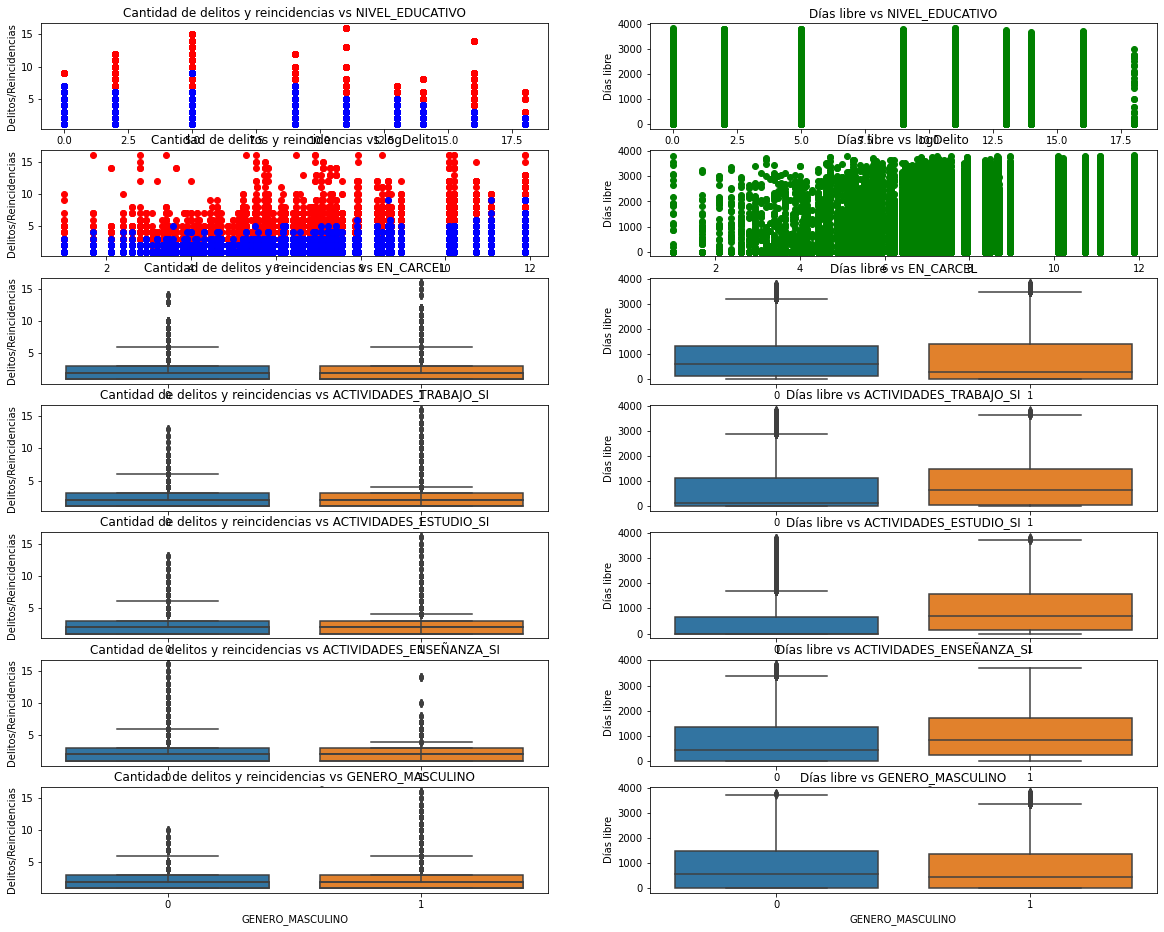

In [129]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from plotly.subplots import make_subplots
import math
#fig = make_subplots(rows=4,cols=2)
i=1
#fig = plt.figure(figsize=(20,16))
fig,ax = plt.subplots(math.ceil(len(covariates)),2,figsize=(20,16))
for col in covariates:
    print(i)
    if i < 5:
        plt.subplot(math.ceil(len(covariates)),2,i)

        plt.scatter(x=df_mj_cp[col],y=df_mj_cp['CANTIDAD_DELITOS'],color='red')
        plt.scatter(x=df_mj_cp[col],y=df_mj_cp['NUMERO_REINCIDENCIAS'],color='blue')
        #plt.legend(loc='best')
        plt.xlabel(col)
        plt.ylabel('Delitos/Reincidencias')
        plt.title('Cantidad de delitos y reincidencias vs ' + col)
        i=i + 1
        plt.subplot(math.ceil(len(covariates)),2,i)
        plt.scatter(x=df_mj_cp[col],y=df_mj_cp['DIAS_LIBRE'],color='green')

        #plt.legend(loc='best')
        plt.xlabel(col)
        plt.ylabel('Días libre')
        plt.title('Días libre vs ' + col)
    else:
        plt.subplot(math.ceil(len(covariates)),2,i)

        sns.boxplot(x=col,y='CANTIDAD_DELITOS',data=df_mj_cp)
        sns.boxplot(x=col,y='NUMERO_REINCIDENCIAS',data=df_mj_cp)
        #plt.legend(loc='best')
        plt.xlabel(col)
        plt.ylabel('Delitos/Reincidencias')
        plt.title('Cantidad de delitos y reincidencias vs ' + col)
        i=i + 1
        plt.subplot(math.ceil(len(covariates)),2,i)
        sns.boxplot(x=col,y='DIAS_LIBRE',data=df_mj_cp)

        #plt.legend(loc='best')
        plt.xlabel(col)
        plt.ylabel('Días libre')
        plt.title('Días libre vs ' + col)
    i = i + 1
plt.show()

In [ ]:
'''print(math.ceil(i/2))
    print(math.ceil(i/4))
    print("primer")
    fig.add_trace(go.Scatter(
        x=df_mj_cp[col],y=df_mj_cp['CANTIDAD_DELITOS'],
        row=math.ceil(i/2),col=math.ceil(i/4),
    ))
    print("seg")
    fig.add_trace(go.Scatter(
        x=df_mj_cp[col],y=df_mj_cp['NUMERO_REINCIDENCIAS'],
        row=math.ceil(i/2),col=math.ceil(i/4),
    ))
    print("terc")
    fig.add_trace(go.Scatter(
        x=df_mj_cp[col],y=df_mj_cp['DIAS_LIBRE'],
        row=math.ceil(i/2),col=math.ceil(i/4),
    ))'''
    #fig = px.scatter(df_mj_cp,x=col,y='CANTIDAD_DELITOS')
    #px.scatter(df_mj_cp,x=col,y='NUMERO_REINCIDENCIAS')
    #px.scatter(df_mj_cp,x=col,y='DIAS_LIBRE')

In [79]:
df_mj_cp[covariates].describe()

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,GENERO_MASCULINO
count,141110.000000,141314.000000,141314.000000,141314.000000,141314.000000,141314.000000
mean,6.351421,10.502450,0.604208,0.545261,0.665398,0.919385
std,3.517393,1.710422,0.489022,0.497949,0.471853,0.272244
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,10.093469,0.000000,0.000000,0.000000,1.000000
50%,5.000000,11.082596,1.000000,1.000000,1.000000,1.000000
75%,9.000000,11.880779,1.000000,1.000000,1.000000,1.000000
max,18.000000,11.880779,1.000000,1.000000,1.000000,1.000000


In [80]:
def normalize(df):
    result = df.copy()    
    for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)    
    return result

In [174]:
df_norm_covariates = normalize(df_mj_cp[covariates])
df_norm_outputs = normalize(df_mj_cp[outputs])
df_norm_covariates.fillna(0,inplace=True)
df_norm_outputs.fillna(0,inplace=True)

In [175]:
df_nonorm_covariates = df_mj_cp[covariates].copy()
df_nonorm_covariates.fillna(0,inplace=True)
df_nonorm_outputs = df_mj_cp[outputs].copy()
df_nonorm_outputs.fillna(0,inplace=True)

In [176]:
df_norm_covariates['logDelito'] = df_norm_covariates['logDelito']*2.5
df_norm_covariates['NIVEL_EDUCATIVO'] = df_norm_covariates['NIVEL_EDUCATIVO']*1.8
df_norm_covariates['GENERO_MASCULINO'] = df_norm_covariates['GENERO_MASCULINO']*1
df_norm_covariates

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,GENERO_MASCULINO
0,1.1,2.235613,1.0,1.0,0.0,1.0
1,1.1,2.089342,1.0,1.0,0.0,1.0
2,1.1,2.089342,1.0,1.0,0.0,1.0
3,0.5,2.235613,1.0,1.0,0.0,1.0
4,0.2,2.235613,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
141309,0.2,0.159260,0.0,1.0,0.0,1.0
141310,1.1,0.159260,1.0,1.0,0.0,1.0
141311,0.5,0.159260,1.0,0.0,0.0,1.0
141312,0.2,0.159260,1.0,0.0,0.0,1.0


For n_clusters = 2 The average silhouette_score is : 0.26008036942828405
For n_clusters = 3 The average silhouette_score is : 0.28035328750825456
For n_clusters = 4 The average silhouette_score is : 0.35014962389707055
For n_clusters = 5 The average silhouette_score is : 0.36415497594853685
For n_clusters = 6 The average silhouette_score is : 0.396584904642617
For n_clusters = 7 The average silhouette_score is : 0.40235249944834955
For n_clusters = 8 The average silhouette_score is : 0.4224361036311122
For n_clusters = 9 The average silhouette_score is : 0.40252121019306214
For n_clusters = 10 The average silhouette_score is : 0.4074333621319837
For n_clusters = 11 The average silhouette_score is : 0.40973892648793936


Text(0, 0.5, 'silhouette_score')

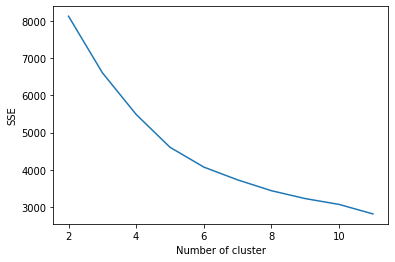

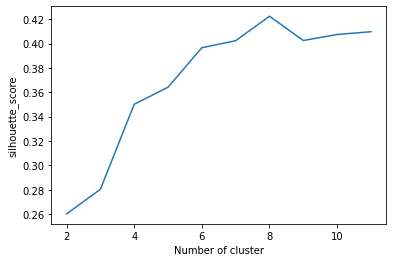

In [177]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

data = df_norm_covariates.sample(10000)
silhouette_array = []
sse = {}
for n_clusters in np.arange(2, 12):

    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data)
    sse[n_clusters] = clusterer.inertia_
    
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_array.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.figure()
plt.plot(np.arange(2,12),silhouette_array)
plt.xlabel("Number of cluster")
plt.ylabel("silhouette_score")

In [144]:
df_norm_covariates.describe()

,NIVEL_EDUCATIVO,logDelito,EN_CARCEL,ACTIVIDADES_TRABAJO_SI,ACTIVIDADES_ESTUDIO_SI,GENERO_MASCULINO
count,141314.000000,141314.000000,141314.000000,141314.000000,141314.000000,141314.000000
mean,0.704695,1.921314,0.604208,0.545261,0.665398,1.103262
std,0.391457,0.345833,0.489022,0.497949,0.471853,0.326692
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.555556,1.838621,0.000000,0.000000,0.000000,1.200000
50%,0.555556,2.038614,1.000000,1.000000,1.000000,1.200000
75%,1.000000,2.200000,1.000000,1.000000,1.000000,1.200000
max,2.000000,2.200000,1.000000,1.000000,1.000000,1.200000


In [123]:
df_norm_covariates_sample = df_norm_covariates.sample(10000)

In [178]:
k=8
clusterer = KMeans(n_clusters=k)
cluster_labels = clusterer.fit_predict(df_norm_covariates)

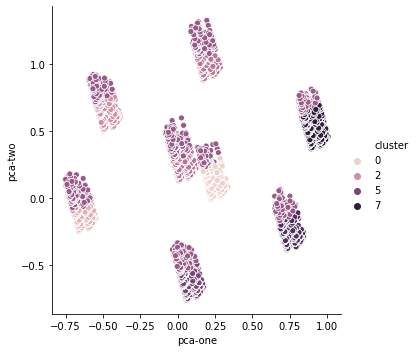

In [179]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit(df_norm_covariates).transform(df_norm_covariates)
datos_pca = df_norm_covariates.copy()
datos_pca['cluster'] = cluster_labels
datos_pca['pca-one'] = X[:,0]
datos_pca['pca-two'] = X[:,1]

sns.relplot(x="pca-one", y="pca-two", hue="cluster", data=datos_pca)

In [180]:
pd.set_option('display.max_columns',500)
df_mj_cp_outcome = df_mj_cp[covariates].copy()
df_mj_cp_outcome.fillna(0,inplace=True)
df_mj_cp_outcome['cluster'] = cluster_labels
df_mj_cp_outcome.groupby(by='cluster').describe()

NIVEL_EDUCATIVO                                                \
                  count      mean       std  min  25%  50%  75%   max   
cluster                                                                 
0                5333.0  6.612976  3.554874  0.0  5.0  5.0  9.0  18.0   
1               25651.0  6.155627  3.467649  0.0  5.0  5.0  9.0  18.0   
2               20255.0  6.388003  3.436956  0.0  5.0  5.0  9.0  18.0   
3               24965.0  6.439055  3.419213  0.0  5.0  5.0  9.0  18.0   
4                7810.0  6.530474  4.159659  0.0  5.0  5.0  9.0  18.0   
5               29352.0  6.192185  3.475388  0.0  2.0  5.0  9.0  18.0   
6               12450.0  6.462490  3.527601  0.0  5.0  5.0  9.0  18.0   
7               15498.0  6.435024  3.590217  0.0  5.0  5.0  9.0  18.0   

        logDelito                                                       \
            count       mean       std       min        25%        50%   
cluster                                                                  
0          5333.0  10.688866  1.520745  5.700480  10.093469  11.082596   
1         25651.0  11.026081  0.997332  7.947937  10.730086  11.082596   
2         20255.0  10.359981  1.413297  6.568345  10.093469  10.730086   
3         24965.0  11.051444  1.028285  7.864848  10.730086  11.082596   
4          7810.0   6.048341  1.389235  1.000000   5.276666   6.220356   
5         29352.0  10.640669  1.358276  6.568345  10.093469  11.082596   
6         12450.0  11.054041  1.251851  6.472271  10.730086  11.880779   
7         15498.0  10.413184  1.712009  4.871201  10.093469  10.730086   

                              EN_CARCEL                                     \
               75%        max     count      mean       std  min  25%  50%   
cluster                                                                      
0        11.880779  11.880779    5333.0  1.000000  0.000000  1.0  1.0  1.0   
1        11.880779  11.880779   25651.0  1.000000  0.000000  1.0  1.0  1.0   
2        11.880779  11.880779   20255.0  1.000000  0.000000  1.0  1.0  1.0   
3        11.880779  11.880779   24965.0  0.000000  0.000000  0.0  0.0  0.0   
4         7.224558   7.947937    7810.0  0.613572  0.486962  0.0  0.0  1.0   
5        11.880779  11.880779   29352.0  1.000000  0.000000  1.0  1.0  1.0   
6        11.880779  11.880779   12450.0  0.000000  0.000000  0.0  0.0  0.0   
7        11.880779  11.880779   15498.0  0.000000  0.000000  0.0  0.0  0.0   

                  ACTIVIDADES_TRABAJO_SI                                     \
         75%  max                  count      mean       std  min  25%  50%   
cluster                                                                       
0        1.0  1.0                 5333.0  0.000000  0.000000  0.0  0.0  0.0   
1        1.0  1.0                25651.0  1.000000  0.000000  1.0  1.0  1.0   
2        1.0  1.0                20255.0  1.000000  0.000000  1.0  1.0  1.0   
3        0.0  0.0                24965.0  1.000000  0.000000  1.0  1.0  1.0   
4        1.0  1.0                 7810.0  0.791549  0.406227  0.0  1.0  1.0   
5        1.0  1.0                29352.0  0.000000  0.000000  0.0  0.0  0.0   
6        0.0  0.0                12450.0  0.000000  0.000000  0.0  0.0  0.0   
7        0.0  0.0                15498.0  0.000000  0.000000  0.0  0.0  0.0   

                  ACTIVIDADES_ESTUDIO_SI                                     \
         75%  max                  count      mean       std  min  25%  50%   
cluster                                                                       
0        0.0  0.0                 5333.0  0.000000  0.000000  0.0  0.0  0.0   
1        1.0  1.0                25651.0  1.000000  0.000000  1.0  1.0  1.0   
2        1.0  1.0                20255.0  0.000000  0.000000  0.0  0.0  0.0   
3        1.0  1.0                24965.0  0.832926  0.373049  0.0  1.0  1.0   
4        1.0  1.0                 7810.0  0.740461  0.438410  0.0  0.0  1.0   
5        0.0  0.0           

In [181]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state = 42)
randomForest.fit(df_mj_cp_outcome[covariates], df_mj_cp_outcome['cluster'])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

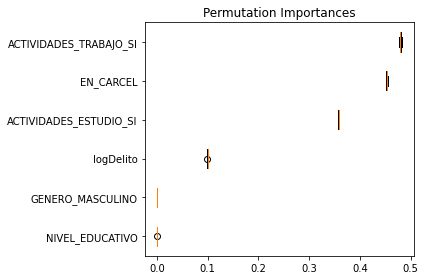

In [182]:
from sklearn.inspection import permutation_importance

result = permutation_importance(randomForest, df_mj_cp_outcome[covariates], df_mj_cp_outcome['cluster'], n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df_mj_cp_outcome[covariates].columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [29]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
tsne = TSNE(n_components=3, verbose=1, perplexity=4, n_iter=300)
tsne_results = tsne.fit_transform(df_norm_covariates)
print(tsne_results)


datos = df_norm_covariates_sample.copy()
datos['cluster'] = cluster_labels
datos['tsne-one'] = tsne_results[:,0]
datos['tsne-two'] = tsne_results[:,1]
datos['tsne-three'] = tsne_results[:,2]

plt.figure(figsize=(16,10))
'''sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="cluster",
    palette=sns.color_palette("hls", k),
    data=datos,
    legend="full",
    alpha=0.3
)'''

fig = go.Figure(data=[go.Surface(x=datos['tsne-one'],
                                 y=datos['tsne-one'],
                                 z=datos['tsne-three'],
                                 color=datos['cluster'])])
fig.show()

[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 141314 samples in 4.689s...
[t-SNE] Computed neighbors for 141314 samples in 33.532s...
[t-SNE] Computed conditional probabilities for sample 1000 / 141314
[t-SNE] Computed conditional probabilities for sample 2000 / 141314
[t-SNE] Computed conditional probabilities for sample 3000 / 141314
[t-SNE] Computed conditional probabilities for sample 4000 / 141314
[t-SNE] Computed conditional probabilities for sample 5000 / 141314
[t-SNE] Computed conditional probabilities for sample 6000 / 141314
[t-SNE] Computed conditional probabilities for sample 7000 / 141314
[t-SNE] Computed conditional probabilities for sample 8000 / 141314
[t-SNE] Computed conditional probabilities for sample 9000 / 141314
[t-SNE] Computed conditional probabilities for sample 10000 / 141314
[t-SNE] Computed conditional probabilities for sample 11000 / 141314
[t-SNE] Computed conditional probabilities for sample 12000 / 141314
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 123000 / 141314
[t-SNE] Computed conditional probabilities for sample 124000 / 141314
[t-SNE] Computed conditional probabilities for sample 125000 / 141314
[t-SNE] Computed conditional probabilities for sample 126000 / 141314
[t-SNE] Computed conditional probabilities for sample 127000 / 141314
[t-SNE] Computed conditional probabilities for sample 128000 / 141314
[t-SNE] Computed conditional probabilities for sample 129000 / 141314
[t-SNE] Computed conditional probabilities for sample 130000 / 141314
[t-SNE] Computed conditional probabilities for sample 131000 / 141314
[t-SNE] Computed conditional probabilities for sample 132000 / 141314
[t-SNE] Computed conditional probabilities for sample 133000 / 141314
[t-SNE] Computed conditional probabilities for sample 134000 / 141314
[t-SNE] Computed conditional probabilities for sample 135000 / 141314
[t-SNE] Computed conditional probabilities for sample 136000 / 141314
[t-SNE] Computed con

KeyboardInterrupt: 